In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/DELL/OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique/Desktop/Machine Learning/FinalMlfast.csv",nrows=100000)


# Step 1: Data Cleaning
## 1.1 Handle missing values

In [4]:
df = df.replace(['', 'N/A', 'null', 'NULL'], np.nan)
initial_na_count = df.isna().sum().sum()
print(f"Total missing values before cleaning: {initial_na_count}")

Total missing values before cleaning: 28206799


In [5]:
missing_percentage = df.isna().mean()
columns_to_drop = missing_percentage[missing_percentage > 0.9].index
df = df.drop(columns=columns_to_drop)
print(f"Dropped {len(columns_to_drop)} columns with >90% missing values.")

# Impute numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

remaining_na_count = df.isna().sum().sum()
print(f"Total missing values after imputation: {remaining_na_count}")

if remaining_na_count > 0:
    print("Warning: Some NaN values remain. Dropping rows with NaN.")
    df = df.dropna()

Dropped 116 columns with >90% missing values.
Total missing values after imputation: 0


## 1.2 Handle outliers in numerical columns (IQR method)

In [7]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
print("Outliers in numerical columns capped using IQR method.")

Outliers in numerical columns capped using IQR method.


## 1.3 Standardize data types

In [9]:
df[numerical_cols] = df[numerical_cols].astype(float)
df[categorical_cols] = df[categorical_cols].astype(str)
print("Data types standardized: numerical to float, categorical to string.")

Data types standardized: numerical to float, categorical to string.


## 1.4 One-hot encoding

In [11]:
df_encoded = pd.get_dummies(df)
print(f"Shape after one-hot encoding: {df_encoded.shape}")

Shape after one-hot encoding: (100000, 941)


## 1.5 Remove low-variance columns

In [13]:
variances = df_encoded.var()
low_variance_cols = variances[variances < 0.01].index
df_encoded = df_encoded.drop(columns=low_variance_cols)
print(f"Removed {len(low_variance_cols)} low-variance columns.")

Removed 768 low-variance columns.


## 1.6 Remove duplicates

In [15]:
initial_rows = len(df_encoded)
df_encoded = df_encoded.drop_duplicates()
print(f"Removed {initial_rows - len(df_encoded)} duplicate rows.")

Removed 2 duplicate rows.


## 1.7 Handle non-finite values in df_encoded

In [17]:
df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan)

### Check for columns with all NaN

In [19]:
all_nan_cols = df_encoded.columns[df_encoded.isna().all()]
if len(all_nan_cols) > 0:
    print(f"Dropping {len(all_nan_cols)} columns with all NaN values.")
    df_encoded = df_encoded.drop(columns=all_nan_cols)

### Impute remaining NaN with column means

In [21]:
df_encoded = df_encoded.fillna(df_encoded.mean())

### Final check for non-finite values

In [23]:
non_finite_cols = df_encoded.columns[~df_encoded.apply(np.isfinite).all()]
if len(non_finite_cols) > 0:
    print(f"Non-finite values found in columns: {non_finite_cols}")
    raise ValueError("DataFrame contains non-finite values after cleaning.")

print("DataFrame is clean and finite.")

DataFrame is clean and finite.


## 1.8 Scale the data

In [25]:
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded)
print("Data scaled using StandardScaler.")

Data scaled using StandardScaler.


# Step 2: K-means Clustering

## Elbow method

In [28]:
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_encoded_scaled)
    inertias.append(kmeans.inertia_)

## Plot elbow curve

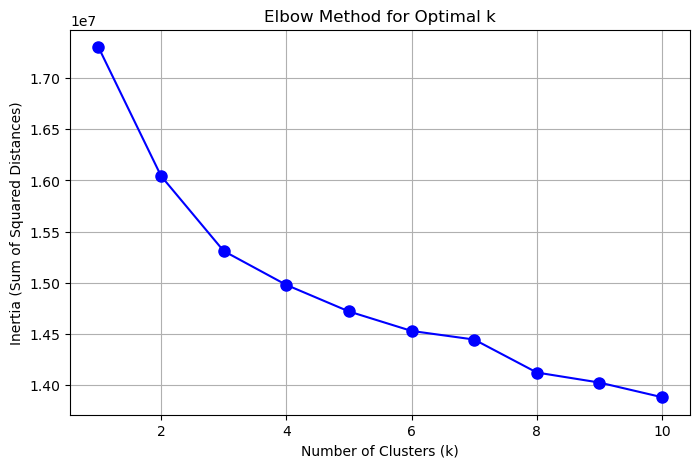

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## Silhouette score

In [32]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_encoded_scaled)
    score = silhouette_score(df_encoded_scaled, labels)
    silhouette_scores.append(score)

## Plot silhouette scores

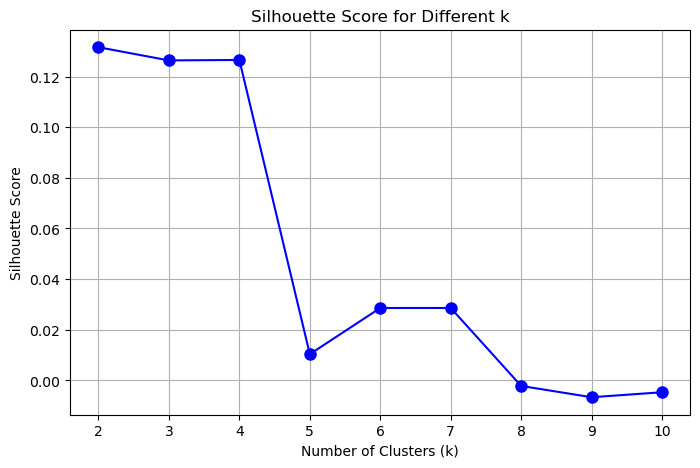

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True)
plt.show()

## Choose optimal k (adjust based on plots)

In [36]:
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_encoded_scaled)

## Output results

In [38]:
print(f"Optimal number of clusters: {optimal_k}")
print(f"Cluster sizes: {np.bincount(cluster_labels)}")
print(f"Silhouette score for k={optimal_k}: {silhouette_score(df_encoded_scaled, cluster_labels):.3f}")

Optimal number of clusters: 3
Cluster sizes: [58807 18448 22743]
Silhouette score for k=3: 0.126


## Add cluster labels to original DataFrame

In [40]:
df['cluster'] = cluster_labels
print("Cluster labels added to original DataFrame.")

ValueError: Length of values (99998) does not match length of index (100000)

Variance explained by PC1: 0.092 (9.2%)
Variance explained by PC2: 0.067 (6.7%)
Variance explained by PC3: 0.040 (4.0%)
Cumulative variance (2D): 0.158 (15.8%)
Cumulative variance (3D): 0.198 (19.8%)


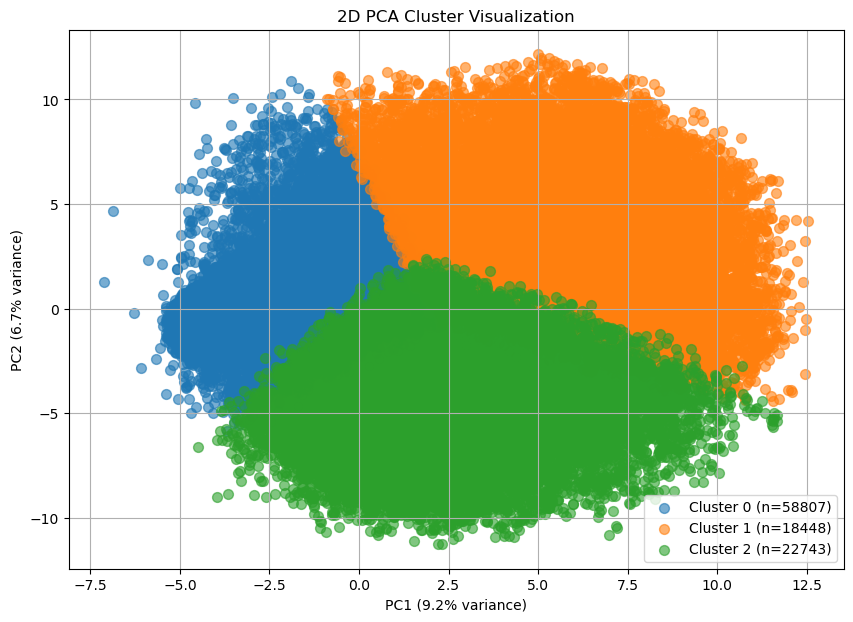

3D plot saved as '3d_cluster_plot.html'. Open in a browser to view.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.offline import plot

# Assuming df_encoded_scaled (5,000 rows, 148 columns) and cluster_labels from your K-means run
# df_encoded_scaled is the scaled, one-hot-encoded data from your previous output
# cluster_labels is the array [0, 1, 2] for each of the 5,000 rows

# Step 1: Apply PCA for 2D and 3D
pca = PCA(n_components=3)  # Get top 3 components for both 2D and 3D
pca_result = pca.fit_transform(df_encoded_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'Cluster': cluster_labels
})

# Variance explained by each component
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)
print(f"Variance explained by PC1: {variance_explained[0]:.3f} ({variance_explained[0]*100:.1f}%)")
print(f"Variance explained by PC2: {variance_explained[1]:.3f} ({variance_explained[1]*100:.1f}%)")
print(f"Variance explained by PC3: {variance_explained[2]:.3f} ({variance_explained[2]*100:.1f}%)")
print(f"Cumulative variance (2D): {cumulative_variance[1]:.3f} ({cumulative_variance[1]*100:.1f}%)")
print(f"Cumulative variance (3D): {cumulative_variance[2]:.3f} ({cumulative_variance[2]*100:.1f}%)")

# Step 2: 2D Scatter Plot (matplotlib)
plt.figure(figsize=(10, 7))
for cluster in range(3):  # Assuming k=3
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                label=f'Cluster {cluster} (n={len(cluster_data)})', 
                alpha=0.6, s=50)
plt.xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)')
plt.title('2D PCA Cluster Visualization')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: 3D Interactive Scatter Plot (plotly)
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=pca_df['Cluster'].astype(str),  # Color by cluster
    title='3D PCA Cluster Visualization',
    labels={
        'PC1': f'PC1 ({variance_explained[0]*100:.1f}% variance)',
        'PC2': f'PC2 ({variance_explained[1]*100:.1f}% variance)',
        'PC3': f'PC3 ({variance_explained[2]*100:.1f}% variance)'
    },
    opacity=0.6,
    size_max=10
)
fig.update_layout(showlegend=True, width=800, height=600)
plot(fig, filename='3d_cluster_plot.html')  # Saves interactive plot to HTML
print("3D plot saved as '3d_cluster_plot.html'. Open in a browser to view.")